# WaveSense: Training a Spiking Neural Network with Temporal Convolutions

In this notebook we will demonstrate how to create and train a WaveSense network as described in https://arxiv.org/pdf/2111.01456.pdf.


The key feature of this model is its temporal convolution layer which is inspired by the famous WaveNet architecture from Google: 
https://arxiv.org/pdf/1609.03499.pdf and
https://deepmind.com/blog/article/wavenet-generative-model-raw-audio
 

<img src="images/wavesense.png" alt="Dilations" width="800"/>


WaveNet uses so called "dilated convolutional layers" as depicted in panel A. Dilated convolutional layers are basically the same as a normal convolutional layers, execpt that the kernel is causal and sparse in the time domain. By choosing the sparseness (dilations) in a smart way, no information is lost but much less parameters have to be trained.

We adapt this method in our spiking neural network implementation. As can be seen in panel A, a dilated connection means that there is a connection which is fast (instantaneous) and one which is delayed by the dilation value. In order to correctly implement that in a SNN, we could simply use an axonal delay for the dilated connection (panel B). Unfortunately, axonal delays are not supported by our hardware. Hence, we chose to represent the fast connection with a synapse having a short time constant and the dilated connection having a long time constant (panel C). Note that this means that our dilated neuron model differs from the standard LIF neuron model as it has two synaptic currents with different time constants.


There are additional parts to the model worth mentioning. The dilated connection happens in a computational block called "WaveBlock". Moreover, the WaveBlock uses a residual connection to connect to the next block and also a skip connection directly to the readout layer. 

The WaveBlock looks like this:

    A single WaveBlock
                          ▲
           To next block  │            ┌────────────┐
       ┌──────────────────┼────────────┤ WaveBlock  ├───┐
       │                  │            └────────────┘   │
       │ Residual path   .─.                            │
       │    ─ ─ ─ ─ ─ ─▶( + )                           │
       │    │            `─'                            │
       │                  ▲                             │
       │    │             │                             │
       │               .─────.                          │
       │    │         ( Spike )                         │
       │               `─────'                          │
       │    │             ▲                             │
       │                  │                             │
       │    │       ┌──────────┐                        │
       │            │  Linear  │                        │
       │    │       └──────────┘         Skip path      │    Skip
       │                  ▲       ┌──────┐    .─────.   │ connections
       │    │             ├──────▶│Linear│──▶( Spike )──┼──────────▶
       │                  │       └──────┘    `─────'   │
       │    │          .─────.                          │
       │              ( Spike )                         │
       │    │          `─────'                          │
       │                 ╲┃╱                            │
       │    │             ┃ Dilation                    │
       │            ┌──────────┐                        │
       │    │       │  Linear  │                        │
       │            └──────────┘                        │
       │    │             ▲                             │
       │     ─ ─ ─ ─ ─ ─ ─│                             │
       └──────────────────┼─────────────────────────────┘
                          │ From previous block
                          │




The WaveSense network stacks multiple such WaveBlocks and adds a two layered readout:




    The WaveSense network
                                                         Threshold
                                                         on output
                                                .───────.
                                               (Low-pass )────▶
                                                `───────'
                                                    ▲
                                                    │
                                              ┌──────────┐
                                              │  Linear  │
                                              └──────────┘
                                                    ▲
                                                    │
                                                 .─────.
                                                ( Spike )
    ┌──────────────────────┐         Skip        `─────'
    │                      ├┐      outputs          ▲
    │   WaveBlock stack    │├┬───┐                  │
    │                      ││├┬──┤      .─.   ┌──────────┐
    └┬─────────────────────┘││├──┴┬───▶( + )─▶│  Linear  │
     └┬─────────────────────┘││───┘     `─'   └──────────┘
      └┬─────────────────────┘│
       └──────────────────────┘
                   ▲
                   │
                .─────.
               ( Spike )
                `─────'
                   ▲
                   │
             ┌──────────┐
             │  Linear  │
             └──────────┘
                   ▲  Spiking
                   │   input

Now, that the model is introduced, let's get started and define the task.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Temporal XOR Task

For demonstation purposes, we want to train the WaveSense model on a toy task which is representative to the tasks it is meant to be applied. We chose the temporal version of logical XOR as it easy but still requires temporal memory, which is the key problem solved by WaveSense.

We create a TemporalXOR task of length `T_total`. 
The created input spike trains contains two stimuli containing `num_channels` neurons of duration `T_stim`.
Between the presentation of the two stimuli is a certain temporal delay which is randomized around `T_delay +- T_randomize`.

```
    | T_Stim |   random delay   | T_Stim  |
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|                                                             |
|                                                             | 
|   FIRST STIM ... Silence ... SECOND STIM ... Silence ...    | 
|                                                             | 
|                                                             |
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 |                        T_total                            |   
 
 Time ->

```
    
The supervision signal is equal to logical XOR(stim_0, stim_1):

```
targets = {
             XOR(Stim_A, Stim_A) = 0
             XOR(Stim_A, Stim_B) = 1
             XOR(Stim_B, Stim_A) = 1
             XOR(Stim_B, Stim_B) = 0
          }
```

The problem which has to be solved is two-fold.

    1) It's non-linear.

    2) It requires temporal memory. The model can only make a decision after both simuli are presented meaning it has to remember the first stimulus for at least the delay period.

In [2]:
from torch.utils.data import Dataset
import torch
import numpy as np

class TemporalXOR(Dataset):
    
    def __init__(self, 
                 T_total=100, 
                 T_stim=20, 
                 T_delay=40, 
                 T_randomize=20,
                 max_num_spikes=15,
                 num_channels=16):

        self.T_total = T_total
        self.T_stim = T_stim
        self.T_delay = T_delay
        self.T_randomize = T_randomize
        self.max_num_spikes = max_num_spikes
        self.num_channels = num_channels

        # two different stimuli
        self.inp_A = torch.randint(0, self.max_num_spikes+1, (self.T_stim, self.num_channels))
        self.inp_A[:, :self.num_channels // 2] = 0
        self.inp_B = torch.randint(0, self.max_num_spikes+1, (self.T_stim, self.num_channels))
        self.inp_B[:, self.num_channels // 2:] = 0

        # stimuli sequence for logical XOR
        self.key_stim_map = {0: [self.inp_A, self.inp_A],
                             1: [self.inp_A, self.inp_B],
                             2: [self.inp_B, self.inp_A],
                             3: [self.inp_B, self.inp_B]}


        # supervision signal for logical XOR
        self.key_target_map = {0: 0, 
                               1: 1, 
                               2: 1, 
                               3: 0}

    def __getitem__(self, key):

        # generate input sample as 
        # [FIRST STIM, ... silence ..., SECOND STIM, ... silence ...]
        inp = torch.zeros(self.T_total, self.num_channels)
        inp[:self.T_stim] = self.key_stim_map[key][0] 
        T_second_stim = self.T_stim + self.T_delay - np.random.randint(-self.T_randomize, self.T_randomize)
        inp[T_second_stim:T_second_stim + self.T_stim] = self.key_stim_map[key][1] 

        # supervision signal
        tgt = torch.Tensor([self.key_target_map[key]]).long()

        return inp, tgt

    def __len__(self):
        return len(self.key_stim_map)

        

In [3]:
from torch.utils.data import DataLoader

data = TemporalXOR(T_total=100, 
                   T_stim=20, 
                   T_delay=30,
                   T_randomize=20,
                   max_num_spikes=15,
                   num_channels=16)
dataloader = DataLoader(data, batch_size=len(data), shuffle=True)


Now that the taks is defined and we created a dataloader, let's visualize the data. 

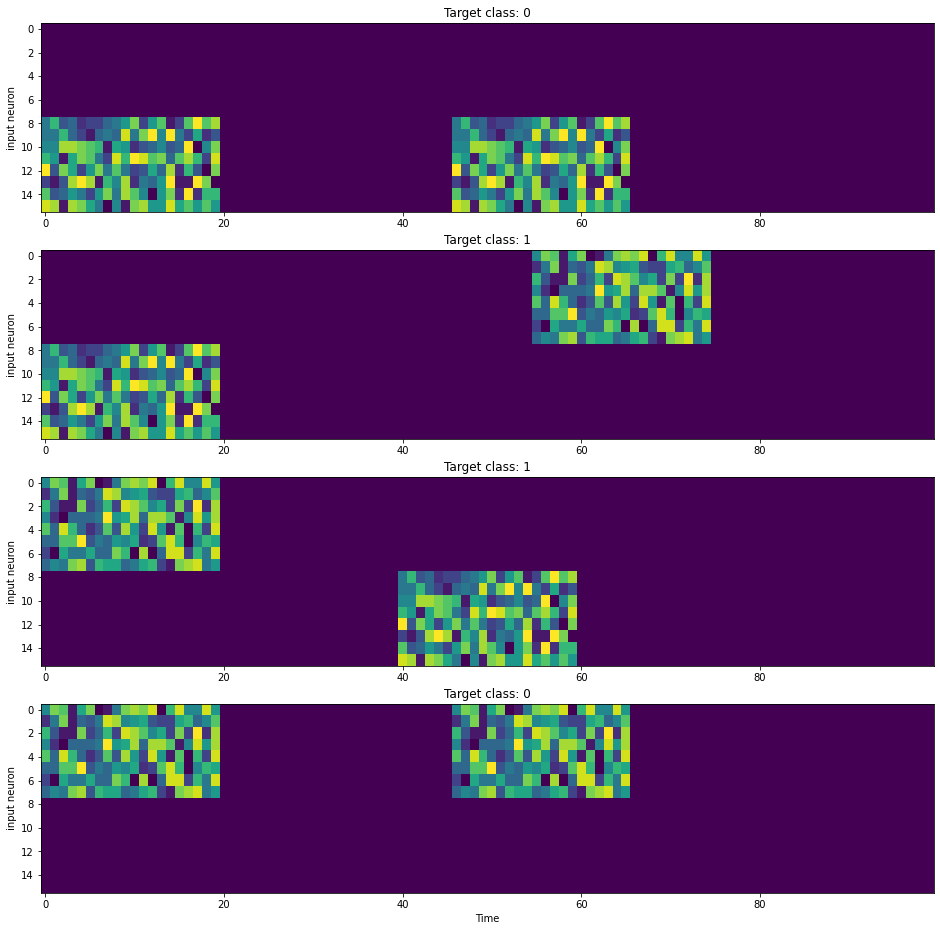

In [4]:
fig = plt.figure(figsize=[16, 16])
for i in range(len(data)):
    inp, target = data[i]
    ax = fig.add_subplot(len(data), 1, i + 1) 
    ax.imshow(inp.T, aspect='auto', interpolation='None')
    ax.set_ylabel("input neuron")
    ax.set_title(f"Target class: {target.item()}")
ax.set_xlabel("Time")
plt.show()

Now let's define the WaveSense network.

As the problem is simple, we use only `16` neurons per layer and `2` WaveBlocks. We want the time constants in the network as short as possible as long time constants blurr the data unnecessarily. On the other hand, we need long memory in the network so we use one long time constant in the second WaveBlock (`dilation = 16`). 

We can define the number of WaveBlocks and their time constants by the `dilations` parameter. Remember, the dilated connection in WaveBlock `i` has two time constants which are calculated as:
```
    tau_syn_0 = base_tau_syn
    tau_syn_1 = dilation[i] * base_tau_syn
```

Finally, WaveSense can low-pass the output of the readout with an exponential kernel (time constant `tau_lp`). This is not strictly necessary but can help to smooth the gradients.

We can also choose which implementation of the LIF neuron WaveSense should use. The options are:

    1) LIFTorch, the most standard LIF dynamics (default)
    2) LIFBitshiftTorch, simulates the bitshift decay as used on Xylo and hence can be successfully quantized after training
    3) LIFSlayer, speeds up the training drastically but won't be able to be quantized after training
    
Here, we use LIFTorch as the most standard implementation of the LIF dynamics.

In [5]:
from rockpool.nn.modules import LIFBitshiftTorch, LIFTorch
from rockpool.nn.networks.wavesense import WaveSenseNet

dilations = [2, 16]
n_out_neurons = 2
n_inp_neurons = data.num_channels
n_neurons = 16 
kernel_size = 2
tau_mem = 0.002
base_tau_syn = 0.002
tau_lp = 0.01
threshold = 1.0
dt = 0.001
device = "cpu" # feel free to use cuda if you have a GPU

model = WaveSenseNet(dilations=dilations,
                     n_classes=n_out_neurons,
                     n_channels_in=n_inp_neurons,
                     n_channels_res=n_neurons,
                     n_channels_skip=n_neurons,
                     n_hidden=n_neurons,
                     kernel_size=kernel_size,
                     has_bias=True,
                     smooth_output=True,
                     tau_mem=tau_mem,
                     base_tau_syn=base_tau_syn,
                     tau_lp=tau_lp,
                     threshold=threshold,
                     neuron_model=LIFTorch,
                     dt=dt,
                     device=device)


Could not import package: 'Brian2'backend not found. Modules that rely on Brian will not be available.
Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: No module named 'iaf_nest'


/home/philipp/projects/rockpool/rockpool/nn/modules/native/linear.py:130: UserWarning: 'Jax' and 'Jaxlib' backend not found. Modules that rely on Jax will not be available.
  warn(
/home/philipp/projects/rockpool/rockpool/nn/modules/native/instant.py:77: UserWarning: 'Jax' and 'Jaxlib' backend not found. Modules that rely on Jax will not be available.
{err}
  warn(
/home/philipp/projects/rockpool/rockpool/nn/modules/__init__.py:33: UserWarning: Jax modules not available: 'Jax' and 'Jaxlib' backend not found. Modules that rely on Jax will not be available.
  warnings.warn(f"Jax modules not available: {err}")
/home/philipp/projects/rockpool/rockpool/utilities/__init__.py:11: UserWarning: Could not import modules: No module named 'jax'
  warnings.warn(f"Could not import modules: {err}")
/home/philipp/projects/rockpool/rockpool/utilities/__init__.py:18: UserWarning: Could not import modules: 'Brian2' backend not found. Modules that rely on Brian will not be available.
  warnings.warn(f"Cou

Now the boilerplate code starts.

We use CrossEntropyLoss as TemporalXOR is a classification task and make use of the Adam optimizer.

In [6]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

crit = CrossEntropyLoss()
opt = Adam(model.parameters().astorch(), lr=5e-3)

We train this model on the TemporalXOR task for `300` epochs. It is worth noting that we apply CrossEntropyLoss only on the last timestep of the output of the model. We do that because we know that the model had the possibility to integrate enough information about the task at the last time step.

In [ ]:
from sklearn.metrics import accuracy_score

num_epochs = 300

# save loss and accuracy over epochs
losses = []
accs = []

# loop over epochs
for epoch in range(num_epochs):
    
    # read one batch of the data
    for inp, tgt in dataloader:
        
        # reset states and gradients
        model.reset_state()
        opt.zero_grad()

        # forward path
        out, _, rec = model(inp.to(device), record=True)
        
        # get the last timestep of the output
        out_at_last_timestep = out[:, -1]
        
        # pass the last timestep of the output and the target through CE
        loss = crit(out_at_last_timestep, tgt.squeeze().to(device))
        
        # backward
        loss.backward()
        
        # apply gradients
        opt.step()

        # save loss and accuracy
        with torch.no_grad():
            pred = out_at_last_timestep.argmax(1)
            accs.append(accuracy_score(tgt.squeeze().cpu().numpy(), pred.cpu().numpy()))
            losses.append(loss.item())

        # print loss and accuracy every 10th epoch
        if epoch % 10 == 0:
            print("epoch", epoch, "loss: ", losses[-1], "acc: ", accs[-1]) 

epoch 0 loss:  4.146129991360011 acc:  0.5
epoch 10 loss:  0.7230686826797884 acc:  0.75
epoch 20 loss:  0.6614829544051175 acc:  0.5
epoch 30 loss:  0.6571636092127511 acc:  0.5
epoch 40 loss:  0.7279486982746981 acc:  0.5
epoch 50 loss:  1.3007905198225271 acc:  0.5
epoch 60 loss:  0.5339137096530044 acc:  1.0
epoch 70 loss:  0.41456784251651013 acc:  0.75
epoch 80 loss:  2.129528437235024 acc:  0.75
epoch 90 loss:  0.018474322757481332 acc:  1.0
epoch 100 loss:  0.0017143633167510009 acc:  1.0
epoch 110 loss:  0.19577798077542466 acc:  0.75


We can visualize the loss and the accuracy over epochs.

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(2, 1, 1) 
ax.plot(losses)
ax.set_title("Loss")
ax.set_ylabel("Loss")
ax.set_yscale('log')
ax = fig.add_subplot(2, 1, 2) 
ax.plot(accs)
ax.set_title("Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.show()

It seems that the model has learned the task successfully. But to make sure, let's visualize the input, and output of the last batch.

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(len(data)):
    ax = fig.add_subplot(2, len(data), i + 1) 
    ax.imshow(inp[i].T, aspect='auto', interpolation='None')
    ax.set_ylabel("input neuron")
    ax = fig.add_subplot(2, len(data), len(data) + i + 1) 
    ax.plot(out[i, :, 0].detach().cpu().numpy(), label='output_0')
    ax.plot(out[i, :, 1].detach().cpu().numpy(), label='output_1')
    ax.legend()
    ax.set_ylabel("output")
    ax.set_xlabel("Time")
plt.show()

As can be seen, the output at the last timestep predicts the target correctly. Output neuron 0 is more active on the last timestep than output neuron 1 if `XOR(inp) == 0` and vice versa.

We can also visualize the activity of each layer in WaveSense by accessing the record dict returned by rockpool on each forward path. We can access the state of each layer (synaptic current and membrane potential) or the spiking output. 

Let's take a look at the spiking output.

In [ ]:
# collect all spiking output from the recordings
spk_layers = []
for name, d in rec.items():
    if "spk" in name:
        spk_layers.append([name, d['spikes']])
    elif "wave" in name:
        wave_name = name
        for name, d in d.items():
            if "spk" in name:
                spk_layers.append([wave_name + " " + name, d['spikes']])

# plot spiking activity over layers                
fig = plt.figure(figsize=(16, 20))
for i, (name, layer_rec) in enumerate(spk_layers):
    ax = fig.add_subplot(len(spk_layers), 1, i+1) 
    img = ax.imshow(layer_rec[0].detach().int().abs().cpu().numpy().T, aspect='auto')
    fig.colorbar(img, ax=ax)
    ax.set_ylabel(name)
ax.set_xlabel("Time")
plt.show()

What we can see here is that the first layers (including the first WaveBlock) respond quickly to the stimuli which is expected as the time constants of those layers are short. 

The second WaveBlock has the only long time constant in the network and is able to maintain an active state for the whole delay period. This reflects the memory in the network and can be utilized by the readout layer (the last layer).

We can save the model to json format using `model.save(path)` and load it again after initialization with `model.load(path)`.

In [ ]:
# save model
#model.save("WaveSense.json")

# load model
#model.load("WaveSense.json")